# **Connecting Drive to Get Data**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing Required Modules

In [5]:
!pip install pybaselines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 14.6 MB/s 


# **Importing Libraries that will be needed**

In [6]:
import pandas as pd 
import statistics
import numpy as np
import shutil
import warnings
warnings.filterwarnings('ignore')
import os
from pickle import FALSE
import pybaselines
import matplotlib.pyplot as plt
from pybaselines.polynomial import imodpoly

# **Unzipping the Data**

In [7]:
!unzip /content/drive/MyDrive/Baseline_correction_Data.zip

Archive:  /content/drive/MyDrive/Baseline_correction_Data.zip
  inflating: Baseline correction/details.txt  
   creating: Baseline correction/happy data eye tracker/
  inflating: Baseline correction/happy data eye tracker/pupil_positions_01_happy.csv  
  inflating: Baseline correction/happy data eye tracker/pupil_positions_02_happy.csv  
  inflating: Baseline correction/happy data eye tracker/pupil_positions_03_happy.csv  
  inflating: Baseline correction/happy data eye tracker/pupil_positions_04_happy.csv  
  inflating: Baseline correction/happy data eye tracker/pupil_positions_05_happy.csv  
  inflating: Baseline correction/happy data eye tracker/pupil_positions_06_happy.csv  
  inflating: Baseline correction/happy data eye tracker/pupil_positions_07_happy.csv  
  inflating: Baseline correction/happy data eye tracker/pupil_positions_08_happy.csv  
  inflating: Baseline correction/happy data eye tracker/pupil_positions_09_happy.csv  
  inflating: Baseline correction/happy data eye tra

# **Other Functions**

In [8]:
# Median Absolute deviation implementation
n = 1

def remove_outliers(value_list, linear_interpolation):
    threshold = get_threshold(max_absolute_change(
        value_list), median_absolute_deviation(value_list))
    out_value_list = []
    i = 0
    while i < len(value_list) - 1:
        if abs(value_list[i] - value_list[i + 1]) > threshold:
            out_value_list.append(0)
        else:
            out_value_list.append(value_list[i])
        i = i + 1
    out_value_list.append(value_list[i])
    if (linear_interpolation):
        out_value_list = linear_interpolate(out_value_list)
    return out_value_list


def get_threshold(mac, mad):
    return (statistics.median(mac) + n * mad)


def max_absolute_change(val_list):
    out_list = []
    out_list.append(abs(val_list[1] - val_list[0]))
    i = 1
    while i < len(val_list) - 1:
        out_list.append(
            max(abs(val_list[i + 1] - val_list[i]), abs(val_list[i] - val_list[i - 1])))
        i = i + 1
    out_list.append(abs(val_list[i - 2] - val_list[i - 1]))
    return out_list


def median_absolute_deviation(val_list):
    mac = max_absolute_change(val_list)
    median = statistics.median(mac)
    mad_list = []
    i = 0
    for val in mac:
        mad_list.append(abs(val - median))
    return statistics.median(mad_list)


def relative_position_on_removed_outiler(filtered_value_list, original_position):
    if original_position >= len(filtered_value_list):
        return -1
    i = 0
    while i <= original_position:
        if filtered_value_list[i] == 0:
            original_position -= 1
        i += 1
    return original_position


def linear_interpolate(value_list):
    value_list = np.array(value_list)
    value_list = np.where(value_list == 0, np.nan, value_list)
    return pd.Series(value_list).interpolate().array

# **Function For data cleaning**

In [54]:
def datacleaner(filename):

  #read data from file and convert it into dataframe using pandas
  df = pd.read_csv(filename)

  #check that it has been read properly
  # print(df.head)

  #check the column headings
  # print("Columns present in pupil data:")
  # print(list(df.columns))

  #select only data with method pye3d 0.3.0 real-time
  detector_3d = df[df.method == 'pye3d 0.3.0 real-time']

  # select only rows with confidence greater than 90%
  # detector_3d = detector_3d[detector_3d.confidence >= 0.9]
  # if we are removing all the values below 90% confidence, some files are only left with below 1000 records

  # select only data with Right eye
  detector_3d = detector_3d[detector_3d.eye_id == 0]

  print("Initial Records")
  print(detector_3d.shape)

  #removing rows with diameter_3d that is less than or greater than the accepted range
  detector_3d.drop(detector_3d[detector_3d['diameter_3d']<0].index,inplace=True)

  #selecting the required 4 columns
  detector_3d = detector_3d[["pupil_timestamp","eye_id","confidence","diameter_3d"]]

  #removing outliers diameter_3d, so that outliers do not affect the baseline
  an_array = np.array(detector_3d["diameter_3d"])
  an_array = remove_outliers(an_array,True)
  detector_3d["diameter_3d_without_outliers"] = an_array
  # detector_3d.fillna(subset = ['diameter_3d_without_outliers'], axis = 0, inplace = True)
  detector_3d.dropna(subset = ['diameter_3d_without_outliers'], axis = 0, inplace = True)

  
  #baseline correction
  y = np.array(detector_3d['diameter_3d_without_outliers'])
  x = np.array(detector_3d['pupil_timestamp'])
  regular_imodpoly = imodpoly(y,x,poly_order = 5)[0]
  # print("base_line_corrected length : ", len(regular_imodpoly))
  # print(regular_imodpoly)
  detector_3d["base_line_corrected"] = regular_imodpoly
  # print(detector_3d.tail(10))
  # print(regular_imodpoly)



  #check for empty values
  # print(detector_3d.isnull().sum())
  #there were no null values at the time we checked


  # skip first 30 seconds to allow for the 3D model to converge and take mean of first 30 Seconds and calculate the difference
  # start_time = detector_3d.pupil_timestamp.iloc[0] + 30
  # detector_3d_mean_data_below_start = detector_3d[detector_3d.pupil_timestamp <= start_time]
  # print("first 30 seconds involve : ",detector_3d_mean_data_below_start.shape)
  # detector_3d_mean_below_start = np.mean(detector_3d_mean_data_below_start["base_line_corrected"])
  # detector_3d = detector_3d[detector_3d.pupil_timestamp > start_time]
  # print("first 30 seconds involve : ",detector_3d_mean_data_below_start.shape)
  # print("After 30 seconds involve : ",detector_3d.shape)
  # #creating a difference column
  # detector_3d["difference"] = abs(detector_3d["base_line_corrected"] - detector_3d_mean_below_start)

  #if we are using first 30 seconds a lots of data is being lost
  detector_3d_mean_data_below_start = detector_3d.head(100)
  detector_3d_mean_below_start = np.mean(detector_3d_mean_data_below_start["base_line_corrected"])
  detector_3d["difference"] = detector_3d["base_line_corrected"] - detector_3d_mean_below_start
  #calculating the average of first 100 and then subtracting it from all data to calculate difference

  # Rolling, Data Smoothing
  detector_3d["Moving difference"] = detector_3d["difference"].rolling(window= 100).mean()
  # print(detector_3d.head(10))
  # detector_3d.plot.line(x='pupil_timestamp',y='Moving difference')
  # detector_3d.plot.line(x='pupil_timestamp',y=['Moving difference','difference'])

  #after rolling at 100 first 99 cells of moving difference will be null. to remove those null records
  detector_3d.dropna(subset = ['Moving difference'], axis = 0, inplace = True)
  # print(detector_3d.head(10))

 # df["pupil_timestamp"].mean
  #df["base_line_corrected"].mean
  df2 = df[["pupil_timestamp","diameter_3d"]].mean()
  #df["pupil_timestamp"].mean
  
  


  print("confidence")
  print(detector_3d.shape)
  print(df2)






  

# creating folders if they do not exists
  if not os.path.exists("/content/cleaned_data"):
    os.makedirs("/content/cleaned_data")
  if not os.path.exists("/content/cleaned_data/happy"):
    os.makedirs("/content/cleaned_data/happy")
  if not os.path.exists("/content/cleaned_data/sad"):
    os.makedirs("/content/cleaned_data/sad")

  # creating files and storing
  if(filename[-9:-4] == "happy"):
    newfilename = "/content/cleaned_data/" + filename[-9:-4] + "/pupil_positions_" + filename[-12:-10] + "_" + filename[-9:-4] + ".csv"
    detector_3d.plot.line(x='pupil_timestamp',y=['diameter_3d_without_outliers','base_line_corrected'], title = filename[-12:-10] + "_" + filename[-9:-4] + ".csv")
  else:
    newfilename = "/content/cleaned_data/" + filename[-7:-4] + "/pupil_positions_" + filename[-10:-8] + "_" + filename[-7:-4] + ".csv"
    detector_3d.plot.line(x='pupil_timestamp',y=['diameter_3d_without_outliers','base_line_corrected'], title = filename[-10:-8] + "_" + filename[-7:-4] + ".csv")
  detector_3d.to_csv(newfilename)
  

diameter_3d


# **main function**

In File  1
Initial Records
(43178, 34)
confidence
(42851, 8)
pupil_timestamp    10165.664244
diameter_3d            1.502583
dtype: float64
In File  2
Initial Records
(116899, 34)
confidence
(115391, 8)
pupil_timestamp    88195.145952
diameter_3d            1.586487
dtype: float64
In File  3
Initial Records
(62394, 34)
confidence
(62295, 8)
pupil_timestamp    77867.860441
diameter_3d            1.396007
dtype: float64
In File  4
Initial Records
(92920, 34)
confidence
(91795, 8)
pupil_timestamp    362876.438366
diameter_3d             3.031583
dtype: float64
In File  5
Initial Records
(65234, 34)
confidence
(64013, 8)
pupil_timestamp    432447.541798
diameter_3d             0.507230
dtype: float64
In File  6
Initial Records
(60176, 34)
confidence
(60076, 8)
pupil_timestamp    433058.658025
diameter_3d             0.250094
dtype: float64
In File  7
Initial Records
(43816, 34)
confidence
(43515, 8)
pupil_timestamp    55895.304728
diameter_3d            1.520200
dtype: float64
In File  8
I

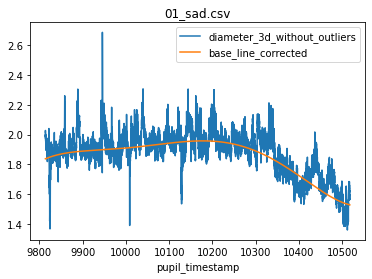

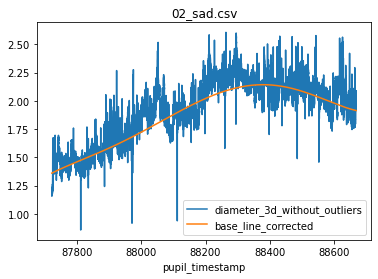

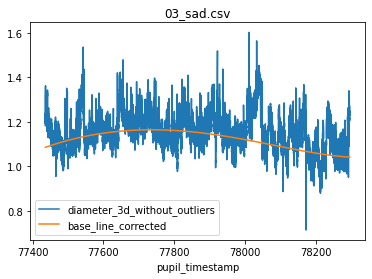

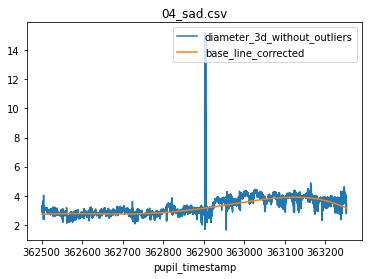

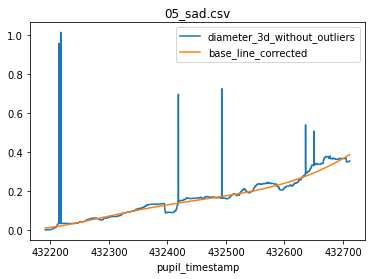

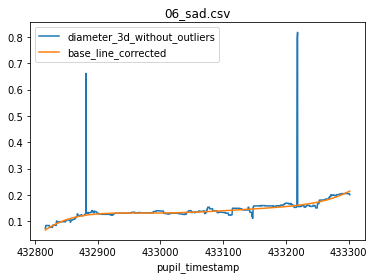

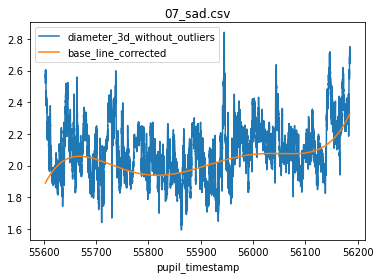

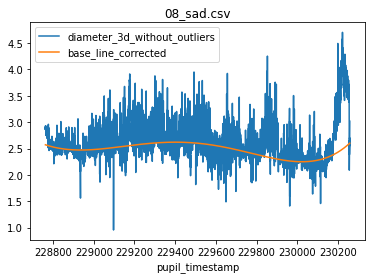

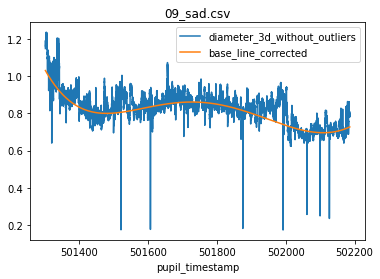

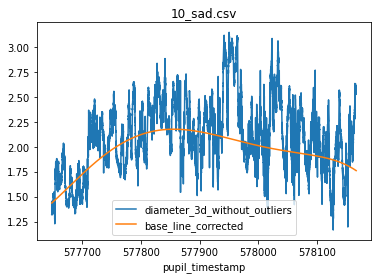

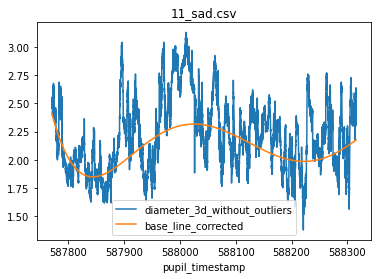

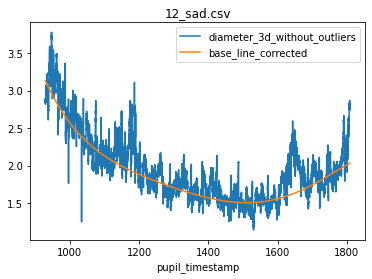

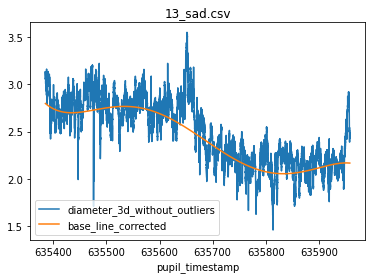

In [57]:
def main():
  # deleting the old files
    # shutil.rmtree('/content/cleaned_data')
    # shutil.rmtree('/content/drive/MyDrive/Data Cleaning and Normalization/cleaned_data.zip')
  # sending happy files to the function
    for i in range(1,14,1):
      filename = "/content/Baseline correction/happy data eye tracker/pupil_positions_" + str(i).zfill(2) + "_happy.csv"
      print("In File ", i)
      datacleaner(filename)
  # sending sad files to the function 
    for i in range(1,14,1):
      filename = "/content/Baseline correction/sad data eye tracker/pupil_positions_" + str(i).zfill(2) + "_sad.csv"
      print("In File ", i)
      datacleaner(filename)

if __name__ == "__main__":
    main()

Together Printer

Happy Shape  (30151, 9)
Sad Shape  (42851, 9)


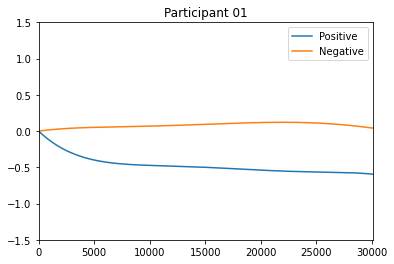

Happy Shape  (65053, 9)
Sad Shape  (115391, 9)


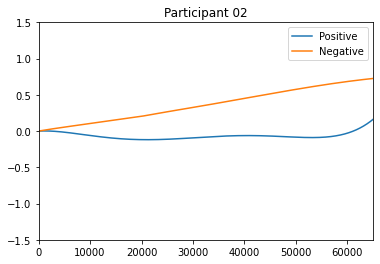

Happy Shape  (59777, 9)
Sad Shape  (62295, 9)


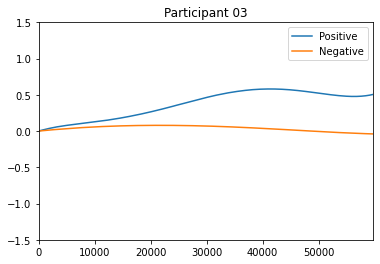

Happy Shape  (91091, 9)
Sad Shape  (91795, 9)


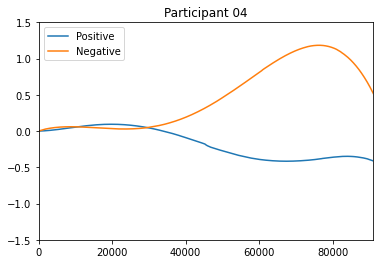

Happy Shape  (72343, 9)
Sad Shape  (64013, 9)


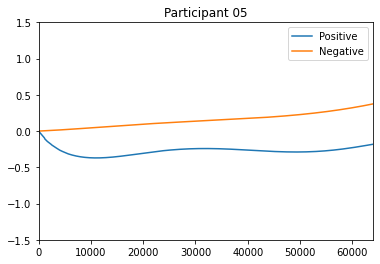

Happy Shape  (55422, 9)
Sad Shape  (60076, 9)


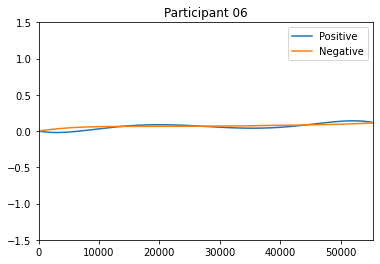

Happy Shape  (33996, 9)
Sad Shape  (43515, 9)


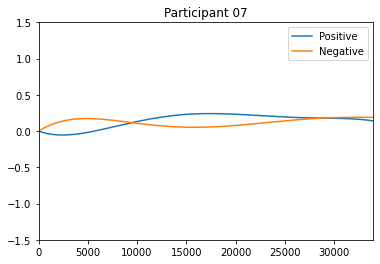

Happy Shape  (51549, 9)
Sad Shape  (153389, 9)


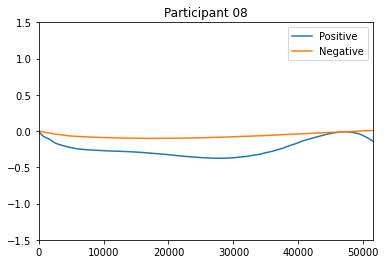

Happy Shape  (31504, 9)
Sad Shape  (108303, 9)


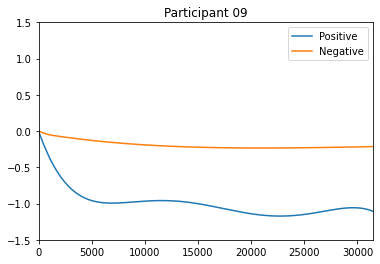

Happy Shape  (61353, 9)
Sad Shape  (63803, 9)


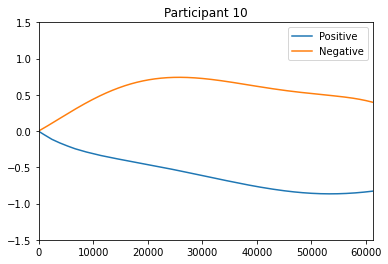

Happy Shape  (68055, 9)
Sad Shape  (67619, 9)


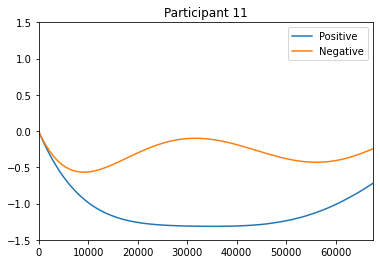

Happy Shape  (67056, 9)
Sad Shape  (108545, 9)


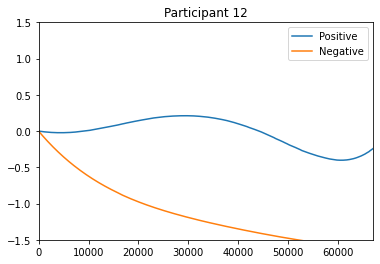

Happy Shape  (58460, 9)
Sad Shape  (69733, 9)


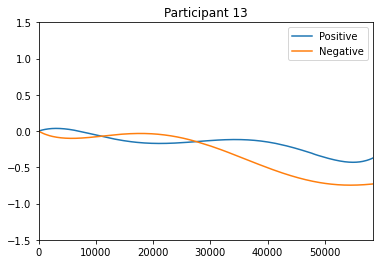

In [58]:
#Happy vs Sad for all participants


def printhappysadtogether():
  for i in range(1,14,1):
    filename = "/content/cleaned_data/happy/pupil_positions_" + str(i).zfill(2) + "_happy.csv"
    df = pd.read_csv(filename)
    print("Happy Shape ", df.shape)
    filename = "/content/cleaned_data/sad/pupil_positions_"+ str(i).zfill(2) + "_sad.csv"
    df1 = pd.read_csv(filename)
    print("Sad Shape ", df1.shape)
    plt.plot(df["Moving difference"],label = "Positive")
    plt.plot(df1["Moving difference"],label = "Negative")
    title = "Participant " + str(i).zfill(2)
    arr = []
    arr.append(df.shape[0])
    arr.append(df1.shape[0])
    plt.xlim([0,min(arr)])
    plt.ylim([-1.5,1.5])
    plt.title(title)
    plt.legend()
    plt.show()

printhappysadtogether()


All Happy and sad Together

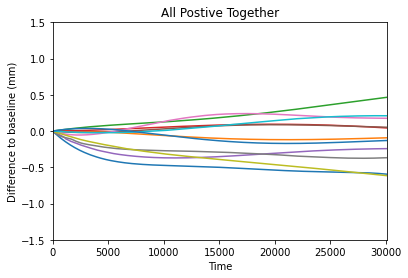

In [116]:
#moving differences of all happy Together
def allhappytogether():
  arr = []
  for i in range(1,14,1):
    filename = "/content/cleaned_data/happy/pupil_positions_" + str(i).zfill(2) + "_happy.csv"
    df = pd.read_csv(filename)
    if(i != 11 and i != 9):
      plt.plot(df["Moving difference"],label = "Participant" + str(i).zfill(2))
    arr.append(df.shape[0])
  plt.xlim([0,min(arr)])
  plt.ylim([-1.5,1.5])
  plt.xlabel("Time")
  plt.ylabel("Difference to baseline (mm)")
  plt.title("All Postive Together")
  plt.savefig('/content/drive/MyDrive/Baseline correction/Positive.png')
  plt.show()

allhappytogether()

All Negative Together

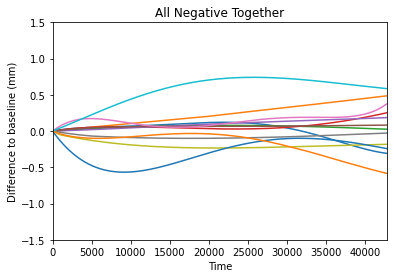

In [59]:
#moving differences of all Sad Together
def allsadtogether():
  arr = []
  for i in range(1,14,1):
    filename = "/content/cleaned_data/sad/pupil_positions_" + str(i).zfill(2) + "_sad.csv"
    df = pd.read_csv(filename)
    if (i != 12):
      plt.plot(df["Moving difference"],label = "Participant" + str(i).zfill(2))
    arr.append(df.shape[0])
  plt.xlim([0,min(arr)])
  plt.ylim([-1.5,1.5])
  plt.xlabel("Time")
  plt.ylabel("Difference to baseline (mm)")
  plt.title("All Negative Together")
  plt.savefig('/content/drive/MyDrive/Baseline correction/Negative.png')
  plt.show()

allsadtogether()

Smartphone Data Cleaner

In File  1
Initial Records
(174, 5)
Final Records
(145, 11)
Frame_No                            102.0000
left_pupil_area_without_outliers    113.0976
dtype: float64
/content/Baseline correction/Sad data smartphone/01_smartphone_sad.csv
/content/cleaned_data/sad_smartphone/01_sad.csv
In File  2
Initial Records
(2377, 5)
Final Records
(2348, 11)
Frame_No                            4221.50000
left_pupil_area_without_outliers      83.17279
dtype: float64
/content/Baseline correction/Sad data smartphone/02_smartphone_sad.csv
/content/cleaned_data/sad_smartphone/02_sad.csv
In File  3
Initial Records
(2557, 5)
Final Records
(2526, 11)
Frame_No                            1294.50000
left_pupil_area_without_outliers      22.56517
dtype: float64
/content/Baseline correction/Sad data smartphone/03_smartphone_sad.csv
/content/cleaned_data/sad_smartphone/03_sad.csv
In File  4
Initial Records
(3675, 5)
Final Records
(3646, 11)
Frame_No                            1852.500000
left_pupil_area_without_ou

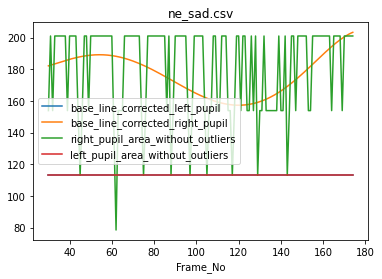

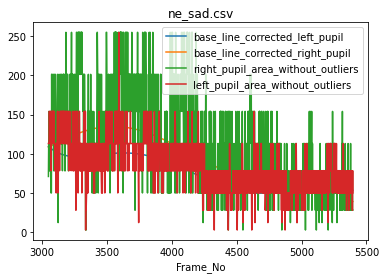

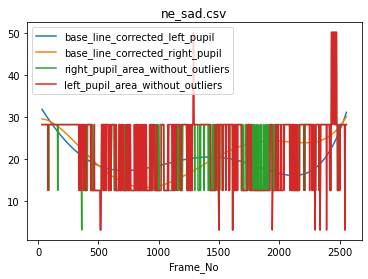

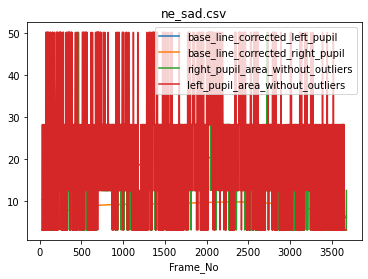

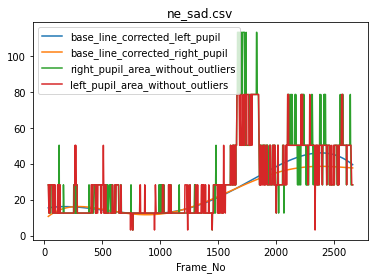

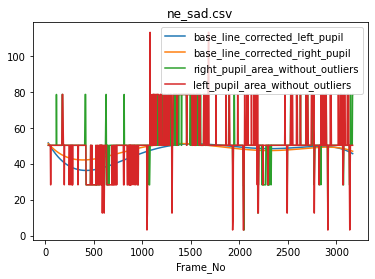

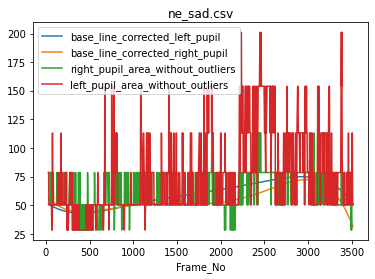

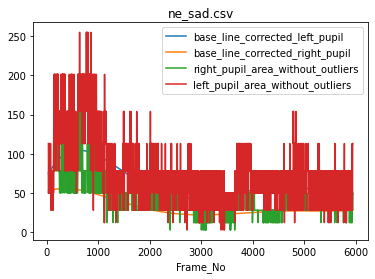

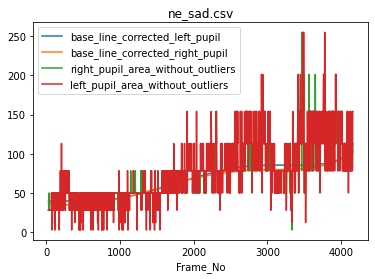

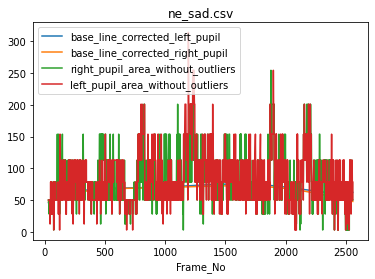

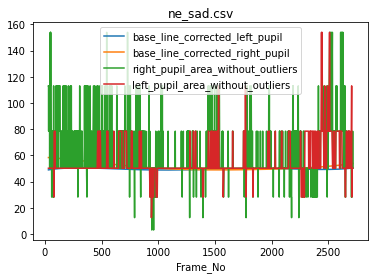

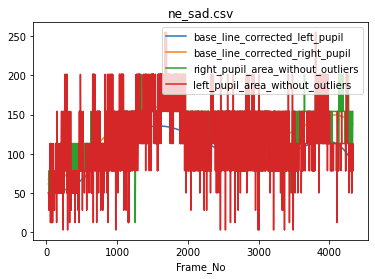

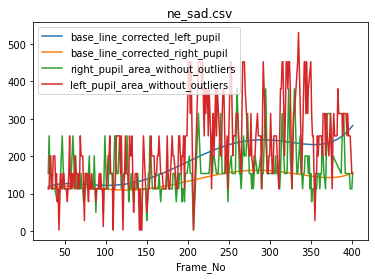

In [64]:
def datacleanersmartphone(filename):

  #read data from file and convert it into dataframe using pandas
  df = pd.read_csv(filename)

  print("Initial Records")
  print(df.shape)


  #selecting the required 4 columns
  df = df[["Frame_No","left_pupil_area","right_pupil_area"]]

  #removing outliers diameter_3d, so that outliers do not affect the baseline
  an_array = np.array(df["left_pupil_area"])
  an_array = remove_outliers(an_array,True)
  df["left_pupil_area_without_outliers"] = an_array
  an_array = np.array(df["right_pupil_area"])
  an_array = remove_outliers(an_array,True)
  df["right_pupil_area_without_outliers"] = an_array
  df.dropna(subset = ['right_pupil_area_without_outliers'], axis = 0, inplace = True)
  df.dropna(subset = ['left_pupil_area_without_outliers'], axis = 0, inplace = True)

  
  #baseline correction
  y = np.array(df["right_pupil_area_without_outliers"])
  x = np.array(df['Frame_No'])
  regular_imodpoly = imodpoly(y,x,poly_order = 5)[0]
  df["base_line_corrected_right_pupil"] = regular_imodpoly

  y = np.array(df["left_pupil_area_without_outliers"])
  x = np.array(df['Frame_No'])
  regular_imodpoly = imodpoly(y,x,poly_order = 5)[0]
  df["base_line_corrected_left_pupil"] = regular_imodpoly


  #if we are using first 30 Frames
  df_mean_data_below_start = df.head(30)
  df_mean_below_start = np.mean(df_mean_data_below_start["base_line_corrected_left_pupil"])
  df["difference_left_pupil"] = df["base_line_corrected_left_pupil"] - df_mean_below_start
  df_mean_below_start = np.mean(df_mean_data_below_start["base_line_corrected_right_pupil"])
  df["difference_right_pupil"] = df["base_line_corrected_right_pupil"] - df_mean_below_start


  # Rolling, Data Smoothing
  df["Moving_difference_left_pupil"] = df["difference_left_pupil"].rolling(window= 30).mean()
  df["Moving_difference_right_pupil"] = df["difference_right_pupil"].rolling(window= 30).mean()

  #after rolling at 30 frames 29 cells of moving difference will be null. to remove those null records
  df.dropna(subset = ['Moving_difference_left_pupil'], axis = 0, inplace = True)
  df.dropna(subset = ['Moving_difference_right_pupil'], axis = 0, inplace = True)

  df3 = df[["Frame_No","left_pupil_area_without_outliers"]].mean()

  print("Final Records")
  print(df.shape)

  print(df3)




  

# creating folders if they do not exists
  if not os.path.exists("/content/cleaned_data"):
    os.makedirs("/content/cleaned_data")
  if not os.path.exists("/content/cleaned_data/happy_smartphone"):
    os.makedirs("/content/cleaned_data/happy_smartphone")
  if not os.path.exists("/content/cleaned_data/sad_smartphone"):
    os.makedirs("/content/cleaned_data/sad_smartphone")

# creating files and storing
  if(filename[-9:-4] == "happy"):
    print
    newfilename = "/content/cleaned_data/" + "happy_smartphone/" + filename[-23:-21] + "_" + filename[-9:-4] + ".csv"
    df.plot.line(x='Frame_No',y=['base_line_corrected_left_pupil','base_line_corrected_right_pupil','right_pupil_area_without_outliers','left_pupil_area_without_outliers'], title = filename[-12:-10] + "_" + filename[-9:-4] + ".csv")
  else:
    newfilename = "/content/cleaned_data/" + "sad_smartphone/" + filename[-21:-19] + "_" +filename[-7:-4] + ".csv"
    df.plot.line(x='Frame_No',y=['base_line_corrected_left_pupil','base_line_corrected_right_pupil','right_pupil_area_without_outliers','left_pupil_area_without_outliers'], title = filename[-10:-8] + "_" + filename[-7:-4] + ".csv")
  print(filename)
  print(newfilename)
  df.to_csv(newfilename)


# sending happy files to the function
#for i in range(1,14,1):
  #filename = "/content/Baseline correction/happy smartphone/" + str(i).zfill(2) + "_smartphone_happy.csv"
  #print("In File ", i)
  #datacleanersmartphone(filename)
# sending sad files to the function 
for i in range(1,14,1):
  filename = "/content/Baseline correction/Sad data smartphone/" + str(i).zfill(2) + "_smartphone_sad.csv"
  print("In File ", i)
  datacleanersmartphone(filename)

Happy against sad left eye left Pupil

Happy Shape  (71, 12)
Sad Shape  (145, 12)


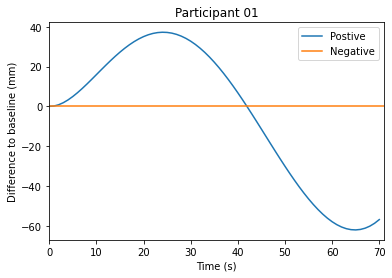

Happy Shape  (5366, 12)
Sad Shape  (2348, 12)


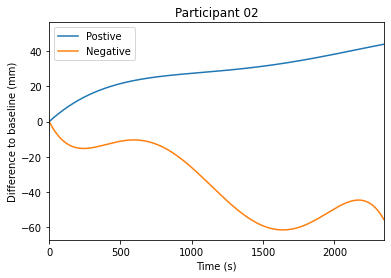

Happy Shape  (3229, 12)
Sad Shape  (2526, 12)


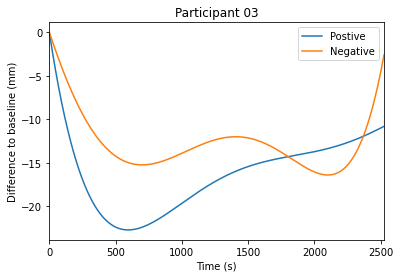

Happy Shape  (3909, 12)
Sad Shape  (3646, 12)


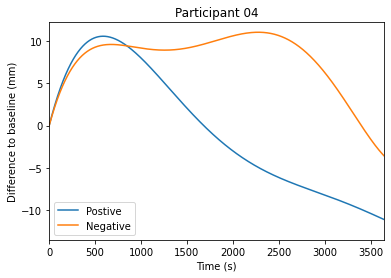

Happy Shape  (3491, 12)
Sad Shape  (2632, 12)


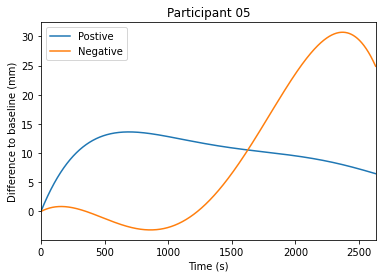

Happy Shape  (2820, 12)
Sad Shape  (3138, 12)


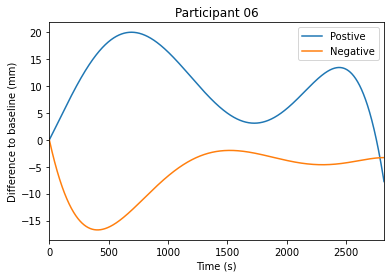

Happy Shape  (3150, 12)
Sad Shape  (3487, 12)


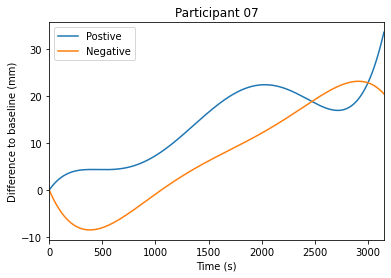

Happy Shape  (1748, 12)
Sad Shape  (5916, 12)


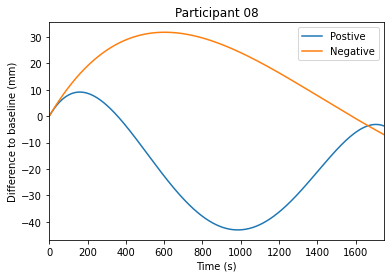

Happy Shape  (2379, 12)
Sad Shape  (4125, 12)


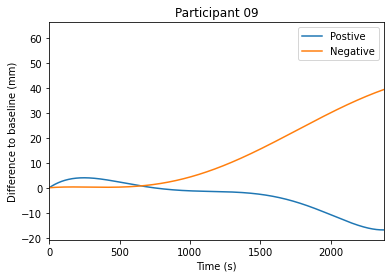

Happy Shape  (2538, 12)
Sad Shape  (2530, 12)


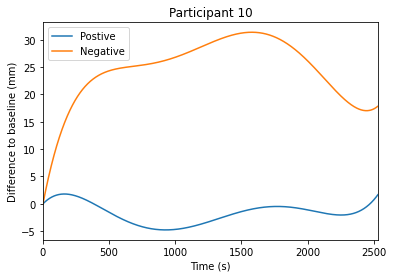

Happy Shape  (2758, 12)
Sad Shape  (2686, 12)


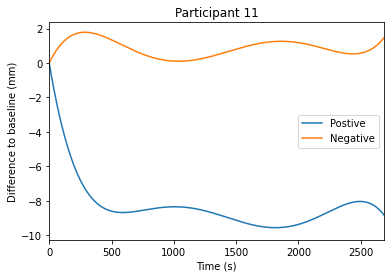

Happy Shape  (2944, 12)
Sad Shape  (4301, 12)


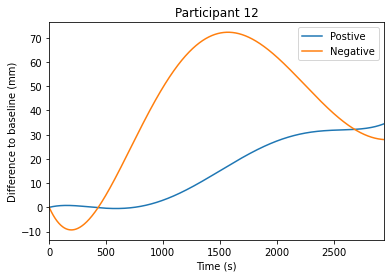

Happy Shape  (2845, 12)
Sad Shape  (372, 12)


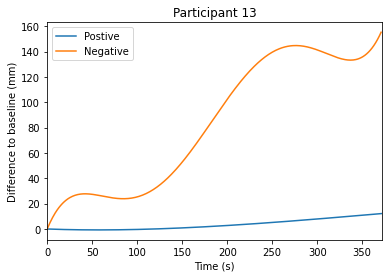

In [119]:
#Happy against sad left eye
def happyagainstsad():
  for i in range(1,14,1):
    filename = "/content/cleaned_data/happy_smartphone/" + str(i).zfill(2) + "_happy.csv"
    df = pd.read_csv(filename)
    print("Happy Shape ", df.shape)
    filename = "/content/cleaned_data/sad_smartphone/"+ str(i).zfill(2) + "_sad.csv"
    df1 = pd.read_csv(filename)
    print("Sad Shape ", df1.shape)
    plt.plot(df["Moving_difference_left_pupil"],label = "Postive")
    plt.plot(df1["Moving_difference_left_pupil"],label = "Negative")
    title = "Participant " + str(i).zfill(2)
    arr = []
    plt.xlabel("Time (s)")
    plt.ylabel("Difference to baseline (mm)")
    arr.append(df.shape[0])
    arr.append(df1.shape[0])
    plt.xlim([0,min(arr)])
    plt.xlabel("Time (s)")
    plt.ylabel("Difference to baseline (mm)")
    plt.title(title)
    plt.legend()
    plt.show()

happyagainstsad()

All Happy Left Pupil Together

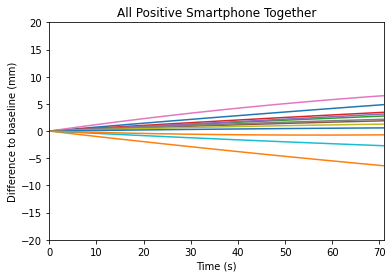

In [121]:
def allhappysmartphone():  
  arr = []
  for i in range(1,14,1):
    filename = "/content/cleaned_data/happy_smartphone/" + str(i).zfill(2) + "_happy.csv"
    df = pd.read_csv(filename)
    if (i != 1):
      plt.plot(df["Moving_difference_left_pupil"],label = "Participant" + str(i).zfill(2))
    arr.append(df.shape[0])
  plt.xlim([0,min(arr)])
  plt.ylim([-20,20])
  plt.xlabel("Time (s)")
  plt.ylabel("Difference to baseline (mm)")
  plt.title("All Positive Smartphone Together")
  plt.savefig('/content/drive/MyDrive/Baseline correction/Positive_smartphone.png')
  plt.show()

allhappysmartphone()

All Sad Left Pupil Together

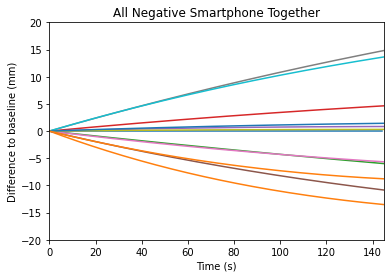

In [122]:
def allsadsmartphone(): 
  arr = []
  for i in range(1,14,1):
    filename = "/content/cleaned_data/sad_smartphone/" + str(i).zfill(2) + "_sad.csv"
    df = pd.read_csv(filename)
    if (i != 13):
      plt.plot(df["Moving_difference_left_pupil"],label = "Participant" + str(i).zfill(2))
    arr.append(df.shape[0])
  plt.xlabel("Time (s)")
  plt.ylabel("Difference to baseline (mm)")
  plt.xlim([0,min(arr)])
  plt.ylim([-20,20])
  plt.title("All Negative Smartphone Together")
  plt.savefig('/content/drive/MyDrive/Baseline correction/Negative_smartphone.png')
  plt.show()
allsadsmartphone()

Ziping the folder and storing it in the drive


In [66]:
!zip -r /content/cleaned_data_new.zip /content/cleaned_data
shutil.copy("/content/drive/MyDrive/cleaned_data_new.zip","/content/drive/MyDrive/Baseline correction")

updating: content/cleaned_data/ (stored 0%)
updating: content/cleaned_data/sad/ (stored 0%)
updating: content/cleaned_data/sad/pupil_positions_13_sad.csv (deflated 63%)
updating: content/cleaned_data/sad/pupil_positions_11_sad.csv (deflated 63%)
updating: content/cleaned_data/sad/pupil_positions_06_sad.csv (deflated 71%)
updating: content/cleaned_data/sad/pupil_positions_04_sad.csv (deflated 61%)
updating: content/cleaned_data/sad/pupil_positions_09_sad.csv (deflated 65%)
updating: content/cleaned_data/sad/pupil_positions_01_sad.csv (deflated 62%)
updating: content/cleaned_data/sad/pupil_positions_03_sad.csv (deflated 61%)
updating: content/cleaned_data/sad/pupil_positions_02_sad.csv (deflated 62%)
updating: content/cleaned_data/sad/pupil_positions_08_sad.csv (deflated 61%)
updating: content/cleaned_data/sad/pupil_positions_05_sad.csv (deflated 68%)
updating: content/cleaned_data/sad/pupil_positions_07_sad.csv (deflated 62%)
updating: content/cleaned_data/sad/pupil_positions_12_sad.csv

'/content/drive/MyDrive/Baseline correction/cleaned_data_new.zip'